In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb

plt.rcParams.update({"font.size": 13})

In [2]:
# Function to visualize censored labels
def plot_censored_labels(
    X: np.ndarray, y_lower: np.ndarray, y_upper: np.ndarray
) -> None:
    def replace_inf(x: np.ndarray, target_value: float) -> np.ndarray:
        x[np.isinf(x)] = target_value
        return x

    plt.plot(X, y_lower, "o", label="y_lower", color="blue")
    plt.plot(X, y_upper, "o", label="y_upper", color="fuchsia")
    plt.vlines(
        X,
        ymin=replace_inf(y_lower, 0.01),
        ymax=replace_inf(y_upper, 1000.0),
        label="Range for y",
        color="gray",
    )

In [3]:
# Toy data
X = np.array([1, 2, 3, 4, 5]).reshape((-1, 1))
INF = np.inf
y_lower = np.array([10, 15, -INF, 30, 100])
y_upper = np.array([INF, INF, 20, 50, INF])

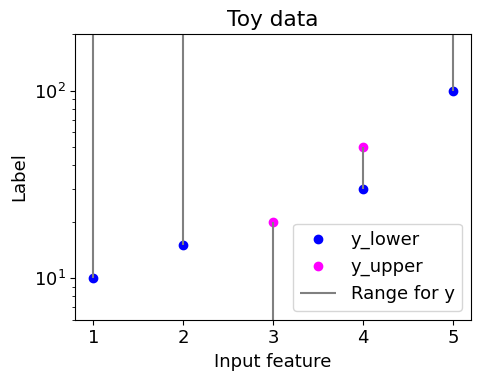

In [4]:
# Visualize toy data
plt.figure(figsize=(5, 4))
plot_censored_labels(X, y_lower, y_upper)
plt.ylim((6, 200))
plt.legend(loc="lower right")
plt.title("Toy data")
plt.xlabel("Input feature")
plt.ylabel("Label")
plt.yscale("log")
plt.tight_layout()
plt.show(block=True)

In [ ]:
# Will be used to visualize XGBoost model
grid_pts = np.linspace(0.8, 5.2, 1000).reshape((-1, 1))

# Train AFT model using XGBoost
dmat = xgb.DMatrix(X)
dmat.set_float_info("label_lower_bound", y_lower)
dmat.set_float_info("label_upper_bound", y_upper)
params = {"max_depth": 3, "objective": "survival:aft", "min_child_weight": 0}

accuracy_history = []


class PlotIntermediateModel(xgb.callback.TrainingCallback):
    """Custom callback to plot intermediate models."""

    def __init__(self) -> None:
        super().__init__()

    def after_iteration(
        self,
        model: xgb.Booster,
        epoch: int,
        evals_log: xgb.callback.TrainingCallback.EvalsLog,
    ) -> bool:
        """Run after training is finished."""
        # Compute y_pred = prediction using the intermediate model, at current boosting
        # iteration
        y_pred = model.predict(dmat)
        # "Accuracy" = the number of data points whose ranged label (y_lower, y_upper)
        #              includes the corresponding predicted label (y_pred)
        acc = np.sum(
            np.logical_and(y_pred >= y_lower, y_pred <= y_upper) / len(X) * 100
        )
        accuracy_history.append(acc)

        # Plot ranged labels as well as predictions by the model
        plt.subplot(5, 3, epoch + 1)
        plot_censored_labels(X, y_lower, y_upper)
        y_pred_grid_pts = model.predict(xgb.DMatrix(grid_pts))
        plt.plot(
            grid_pts, y_pred_grid_pts, "r-", label="XGBoost AFT model", linewidth=4
        )
        plt.title("Iteration {}".format(epoch), x=0.5, y=0.8)
        plt.xlim((0.8, 5.2))
        plt.ylim((1 if np.min(y_pred) < 6 else 6, 200))
        plt.yscale("log")
        return False
res: xgb.callback.TrainingCallback.EvalsLog = {}

[0]	train-aft-nloglik:5.37407
[1]	train-aft-nloglik:3.56799
[2]	train-aft-nloglik:2.51003
[3]	train-aft-nloglik:1.89337
[4]	train-aft-nloglik:1.53043
[5]	train-aft-nloglik:1.24291
[6]	train-aft-nloglik:1.04795
[7]	train-aft-nloglik:0.90452
[8]	train-aft-nloglik:0.79514
[9]	train-aft-nloglik:0.71113
[10]	train-aft-nloglik:0.64616
[11]	train-aft-nloglik:0.59560
[12]	train-aft-nloglik:0.55603
[13]	train-aft-nloglik:0.52490


c:\Users\nguye\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:723: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[14]	train-aft-nloglik:0.50029


C:\Users\nguye\AppData\Local\Temp\ipykernel_15680\4266282319.py:17: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


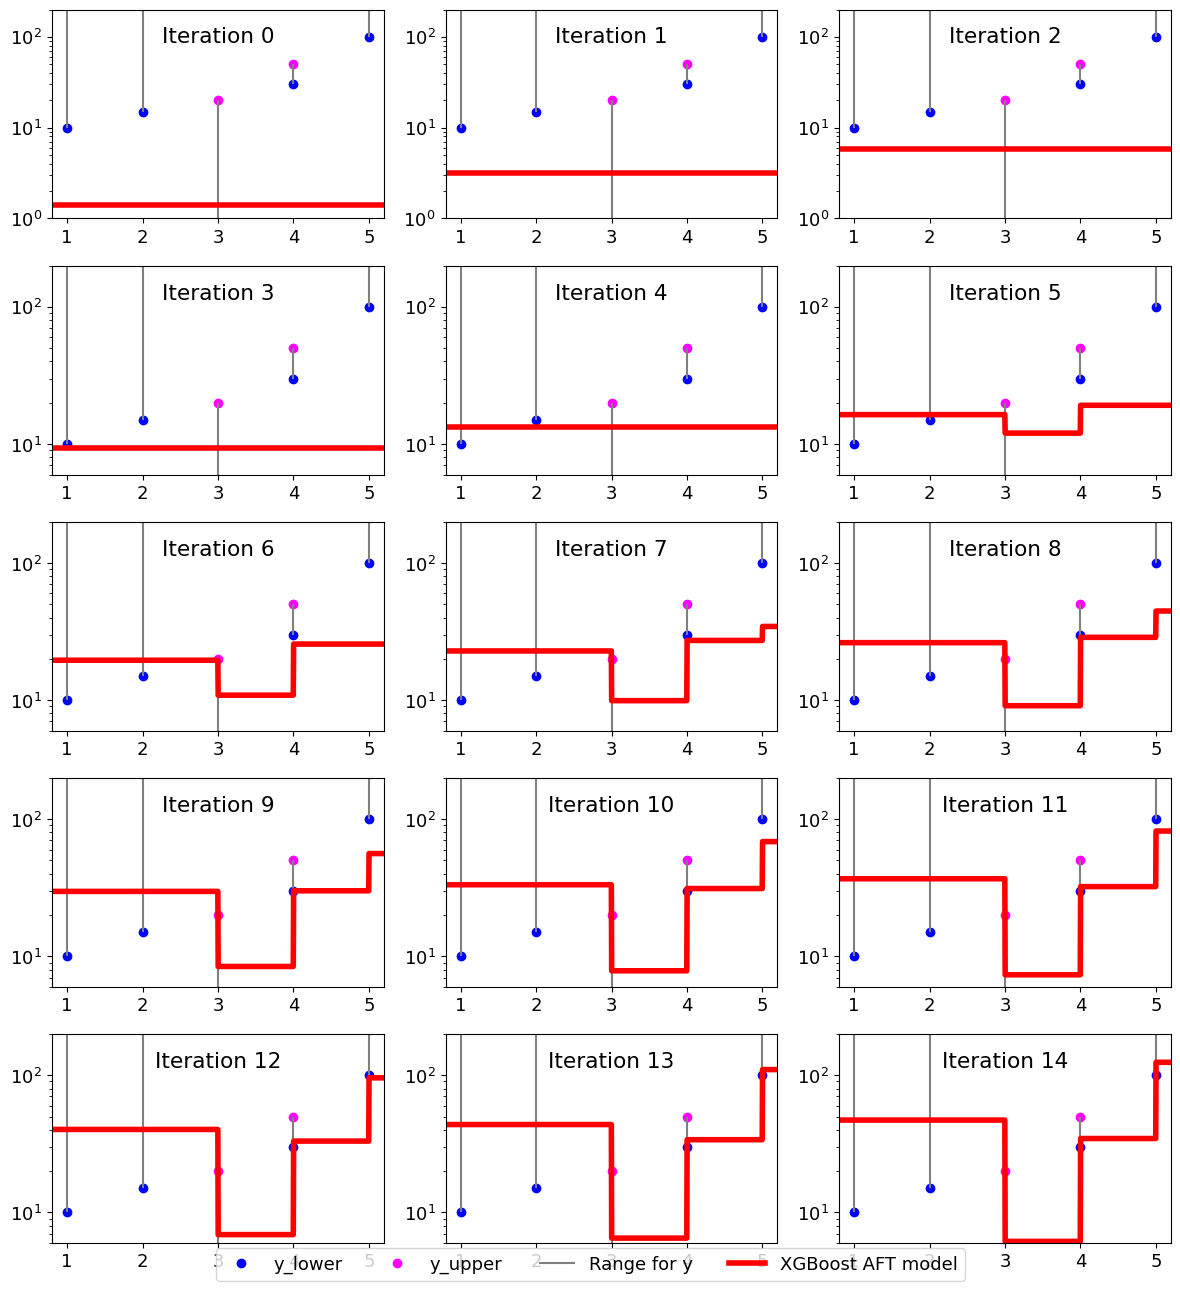

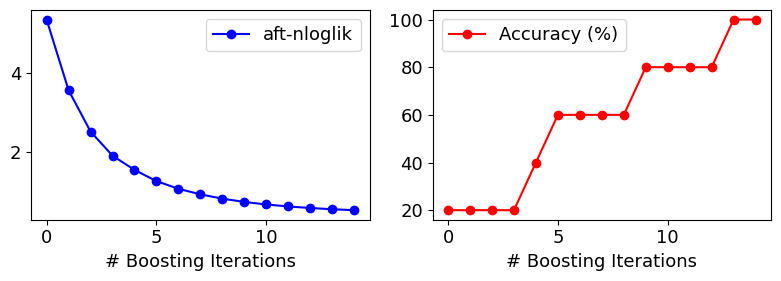

In [6]:
plt.figure(figsize=(12, 13))
bst = xgb.train(
    params,
    dmat,
    15,
    [(dmat, "train")],
    evals_result=res,
    callbacks=[PlotIntermediateModel()],
)
plt.tight_layout()
plt.legend(
    loc="lower center",
    ncol=4,
    bbox_to_anchor=(0.5, 0),
    bbox_transform=plt.gcf().transFigure,
)
plt.tight_layout()

# Plot negative log likelihood over boosting iterations
plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.plot(res["train"]["aft-nloglik"], "b-o", label="aft-nloglik")
plt.xlabel("# Boosting Iterations")
plt.legend(loc="best")

# Plot "accuracy" over boosting iterations
# "Accuracy" = the number of data points whose ranged label (y_lower, y_upper) includes
#              the corresponding predicted label (y_pred)
plt.subplot(1, 2, 2)
plt.plot(accuracy_history, "r-o", label="Accuracy (%)")
plt.xlabel("# Boosting Iterations")
plt.legend(loc="best")
plt.tight_layout()

plt.show()